In [1]:
import pandas as pd
from pathlib import Path

# Your raw data path
RAW_PATH = "/Users/darrelljarrett/NBA PREDICTOR PROJECT/games.csv"

# Create output folders
Path("data/proc").mkdir(parents=True, exist_ok=True)

# Load
df = pd.read_csv(RAW_PATH)
print(df.shape)
df.head()

(26651, 21)


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [2]:
required = [
    "GAME_DATE_EST","SEASON","HOME_TEAM_ID","VISITOR_TEAM_ID",
    "PTS_home","PTS_away","HOME_TEAM_WINS"
]
missing = [c for c in required if c not in df.columns]
print("Missing:", missing)

Missing: []


In [3]:
# home
home = df[[
    "GAME_DATE_EST","SEASON","HOME_TEAM_ID","VISITOR_TEAM_ID",
    "PTS_home","PTS_away","HOME_TEAM_WINS"
]].rename(columns={
    "GAME_DATE_EST":"date",
    "HOME_TEAM_ID":"team",
    "VISITOR_TEAM_ID":"opp",
    "PTS_home":"pts",
    "PTS_away":"opp_pts",
    "HOME_TEAM_WINS":"win"
})
home["home"] = 1

# away
away = df[[
    "GAME_DATE_EST","SEASON","VISITOR_TEAM_ID","HOME_TEAM_ID",
    "PTS_away","PTS_home","HOME_TEAM_WINS"
]].rename(columns={
    "GAME_DATE_EST":"date",
    "VISITOR_TEAM_ID":"team",
    "HOME_TEAM_ID":"opp",
    "PTS_away":"pts",
    "PTS_home":"opp_pts",
    "HOME_TEAM_WINS":"home_team_win"
})
away["win"] = 1 - away["home_team_win"]
away["home"] = 0
away = away.drop(columns=["home_team_win"])

# combine
games_std = pd.concat([home, away], ignore_index=True)
games_std["date"] = pd.to_datetime(games_std["date"], errors="coerce")
games_std = games_std.sort_values("date").reset_index(drop=True)

games_std.head()

,date,SEASON,team,opp,pts,opp_pts,win,home
0,2003-10-05,2003,1610612762,1610612742,90.0,85.0,1,1
1,2003-10-05,2003,1610612742,1610612762,85.0,90.0,0,0
2,2003-10-06,2003,1610612749,1610612763,94.0,105.0,0,0
3,2003-10-06,2003,1610612763,1610612749,105.0,94.0,1,1
4,2003-10-07,2003,1610612747,1610612744,NaN,NaN,0,1


In [4]:
# === Feature Engineering Block (safe against leakage) ===
import pandas as pd
import numpy as np

# Start from the standardized team-game table
g = games_std.copy()
g = g.sort_values(['team', 'date']).reset_index(drop=True)

# Helper: rolling mean of *past* games (shift(1) prevents using current game info)
def past_mean(s, w):
    return s.shift(1).rolling(w, min_periods=1).mean()

# Rolling features for recent form & scoring (3, 5, 10 games)
for w in (3, 5, 10):
    g[f'roll_win_{w}']     = g.groupby('team')['win']    .transform(lambda s: past_mean(s, w))
    g[f'roll_pts_{w}']     = g.groupby('team')['pts']    .transform(lambda s: past_mean(s, w))
    g[f'roll_opp_pts_{w}'] = g.groupby('team')['opp_pts'].transform(lambda s: past_mean(s, w))

# Rest days since last game (clip to a reasonable range to reduce outliers)
g['rest_days'] = g.groupby('team')['date'].diff().dt.days.fillna(3).clip(0, 10)

# Opponent recent form (join opponent's pregame 5-game rolling stats on same date)
opp_cols = ['team', 'date', 'roll_win_5', 'roll_pts_5', 'roll_opp_pts_5']
opp_feats = g[opp_cols].rename(columns={
    'team': 'opp',
    'roll_win_5': 'opp_roll_win_5',
    'roll_pts_5': 'opp_roll_pts_5',
    'roll_opp_pts_5': 'opp_roll_opp_pts_5'
})
g = g.merge(opp_feats, on=['opp', 'date'], how='left')

# Drop rows that don't have enough prior history to compute opponent features
g = g.dropna(subset=['roll_win_5', 'opp_roll_win_5']).reset_index(drop=True)

# Final feature set for models
feature_cols = [
    'home', 'rest_days',
    'roll_win_3', 'roll_win_5', 'roll_win_10',
    'roll_pts_3', 'roll_pts_5', 'roll_pts_10',
    'opp_roll_win_5', 'opp_roll_pts_5'
]

# X/y matrices
X = g[feature_cols].astype(float).values
y = g['win'].astype(int).values

print("Feature matrix shape:", X.shape, " Target shape:", y.shape)
print("Date range:", g['date'].min(), "→", g['date'].max())

Feature matrix shape: (53378, 10)  Target shape: (53378,)
Date range: 2003-10-08 00:00:00 → 2022-12-22 00:00:00


In [5]:
# sort globally by date so splits respect time
gx = pd.DataFrame(g).sort_values('date').reset_index(drop=True)

feature_cols = [
    'home','rest_days',
    'roll_win_3','roll_win_5','roll_win_10',
    'roll_pts_3','roll_pts_5','roll_pts_10',
    'opp_roll_win_5','opp_roll_pts_5'
]

X = gx[feature_cols].astype(float).values
y = gx['win'].astype(int).values

n = len(gx)
i1, i2 = int(n*0.8), int(n*0.9)

X_train, y_train = X[:i1], y[:i1]
X_valid, y_valid = X[i1:i2], y[i1:i2]
X_test,  y_test  = X[i2:],  y[i2:]

print("sizes:", len(y_train), len(y_valid), len(y_test))
print("ranges:",
      gx['date'].iloc[0], "→", gx['date'].iloc[i1-1], "|",
      gx['date'].iloc[i1], "→", gx['date'].iloc[i2-1], "|",
      gx['date'].iloc[i2], "→", gx['date'].iloc[-1])

sizes: 42702 5338 5338
ranges: 2003-10-08 00:00:00 → 2018-12-18 00:00:00 | 2018-12-18 00:00:00 → 2021-02-19 00:00:00 | 2021-02-19 00:00:00 → 2022-12-22 00:00:00


In [6]:
import pandas as pd

pd.DataFrame({
    'nan_rate': pd.isna(gx[feature_cols]).mean().sort_values(ascending=False)
})

,nan_rate
roll_pts_3,0.002810
roll_pts_5,0.001911
opp_roll_pts_5,0.001911
roll_pts_10,0.000731
home,0.000000
rest_days,0.000000
roll_win_3,0.000000
roll_win_5,0.000000
roll_win_10,0.000000
opp_roll_win_5,0.000000


In [7]:
# === Step 7: Train models (handles NaN safely) ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
import numpy as np

def evaluate(name, clf, X_tr, y_tr, X_va, y_va, X_te, y_te):
    clf.fit(X_tr, y_tr)

    def scores(X, y):
        p = clf.predict_proba(X)[:,1]
        return {
            "acc": accuracy_score(y, (p>=0.5).astype(int)),
            "auc": roc_auc_score(y, p),
            "brier": brier_score_loss(y, p)
        }

    s_tr, s_va, s_te = scores(X_tr, y_tr), scores(X_va, y_va), scores(X_te, y_te)
    print(f"\n{name}")
    print(f"  train  acc={s_tr['acc']:.3f}  auc={s_tr['auc']:.3f}  brier={s_tr['brier']:.3f}")
    print(f"  valid  acc={s_va['acc']:.3f}  auc={s_va['auc']:.3f}  brier={s_va['brier']:.3f}")
    print(f"  test   acc={s_te['acc']:.3f}  auc={s_te['auc']:.3f}  brier={s_te['brier']:.3f}")
    return clf


#Logistic Regression (imputer + scaler)
logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])
logreg = evaluate("LogisticRegression", logreg, X_train, y_train, X_valid, y_valid, X_test, y_test)


#Random Forest (imputer only; trees don't need scaling)
rf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
)
rf = evaluate("RandomForest", rf, X_train, y_train, X_valid, y_valid, X_test, y_test)


#Gradient Boosting (imputer)
gb = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(random_state=42)
)
gb = evaluate("GradientBoosting", gb, X_train, y_train, X_valid, y_valid, X_test, y_test)


LogisticRegression
  train  acc=0.626  auc=0.677  brier=0.226
  valid  acc=0.588  auc=0.628  brier=0.238
  test   acc=0.594  auc=0.633  brier=0.238

RandomForest
  train  acc=0.994  auc=1.000  brier=0.074
  valid  acc=0.573  auc=0.606  brier=0.246
  test   acc=0.587  auc=0.614  brier=0.245

GradientBoosting
  train  acc=0.636  auc=0.688  brier=0.223
  valid  acc=0.584  auc=0.626  brier=0.240
  test   acc=0.589  auc=0.628  brier=0.240


In [8]:
# === Step 7B: Tree-based models ===
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Reuse the same evaluate() function from before

# Random Forest (robust baseline)
rf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
)
rf = evaluate("RandomForest", rf, X_train, y_train, X_valid, y_valid, X_test, y_test)

# Gradient Boosting (stronger, slower)
gb = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(random_state=42)
)
gb = evaluate("GradientBoosting", gb, X_train, y_train, X_valid, y_valid, X_test, y_test)


RandomForest
  train  acc=0.994  auc=1.000  brier=0.074
  valid  acc=0.573  auc=0.606  brier=0.246
  test   acc=0.587  auc=0.614  brier=0.245

GradientBoosting
  train  acc=0.636  auc=0.688  brier=0.223
  valid  acc=0.584  auc=0.626  brier=0.240
  test   acc=0.589  auc=0.628  brier=0.240


In [9]:
# === Step 8: Add New Features (back-to-back + month) and Rebuild Splits ===

g2 = g.copy()

# Back-to-back (0 rest days)
g2['b2b'] = (g2['rest_days'] == 0).astype(int)

# Month of game
g2['month'] = g2['date'].dt.month.astype(int)

# Updated features
feature_cols = [
    'home','rest_days','b2b','month',
    'roll_win_3','roll_win_5','roll_win_10',
    'roll_pts_3','roll_pts_5','roll_pts_10',
    'opp_roll_win_5','opp_roll_pts_5'
]

# Sort and rebuild X/y
gx = g2.sort_values('date').reset_index(drop=True)
X = gx[feature_cols].astype(float).values
y = gx['win'].astype(int).values

# Chronological split
n = len(gx)
i1, i2 = int(n*0.8), int(n*0.9)
X_train, y_train = X[:i1], y[:i1]
X_valid, y_valid = X[i1:i2], y[i1:i2]
X_test,  y_test  = X[i2:],  y[i2:]

print("sizes:", len(y_train), len(y_valid), len(y_test))
print("ranges:",
      gx['date'].iloc[0], "→", gx['date'].iloc[i1-1], "|",
      gx['date'].iloc[i1], "→", gx['date'].iloc[i2-1], "|",
      gx['date'].iloc[i2], "→", gx['date'].iloc[-1])

sizes: 42702 5338 5338
ranges: 2003-10-08 00:00:00 → 2018-12-18 00:00:00 | 2018-12-18 00:00:00 → 2021-02-19 00:00:00 | 2021-02-19 00:00:00 → 2022-12-22 00:00:00


In [10]:
# === Step 9: Retrain Models with New Features ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
import numpy as np

def evaluate(name, clf, X_tr, y_tr, X_va, y_va, X_te, y_te):
    clf.fit(X_tr, y_tr)
    def scores(X, y):
        p = clf.predict_proba(X)[:,1]
        return {
            "acc": accuracy_score(y, (p>=0.5).astype(int)),
            "auc": roc_auc_score(y, p),
            "brier": brier_score_loss(y, p)
        }
    s_tr, s_va, s_te = scores(X_tr, y_tr), scores(X_va, y_va), scores(X_te, y_te)
    print(f"\n{name}")
    print(f"  train  acc={s_tr['acc']:.3f}  auc={s_tr['auc']:.3f}  brier={s_tr['brier']:.3f}")
    print(f"  valid  acc={s_va['acc']:.3f}  auc={s_va['auc']:.3f}  brier={s_va['brier']:.3f}")
    print(f"  test   acc={s_te['acc']:.3f}  auc={s_te['auc']:.3f}  brier={s_te['brier']:.3f}")
    return clf


# Logistic Regression
logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])
logreg = evaluate("LogisticRegression", logreg, X_train, y_train, X_valid, y_valid, X_test, y_test)

# Random Forest (regularized)
rf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=600,
        max_depth=12,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
)
rf = evaluate("RandomForest", rf, X_train, y_train, X_valid, y_valid, X_test, y_test)

# Gradient Boosting (fine-tuned)
gb = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    )
)
gb = evaluate("GradientBoosting", gb, X_train, y_train, X_valid, y_valid, X_test, y_test)


LogisticRegression
  train  acc=0.627  auc=0.677  brier=0.226
  valid  acc=0.587  auc=0.628  brier=0.238
  test   acc=0.594  auc=0.633  brier=0.238

RandomForest
  train  acc=0.732  auc=0.810  brier=0.191
  valid  acc=0.578  auc=0.618  brier=0.241
  test   acc=0.596  auc=0.629  brier=0.239

GradientBoosting
  train  acc=0.639  auc=0.692  brier=0.222
  valid  acc=0.587  auc=0.624  brier=0.241
  test   acc=0.588  auc=0.623  brier=0.242


In [11]:
!pip install seaborn

In [12]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


/var/folders/sf/2vm40zb10zn8wlj9101w66qw0000gn/T/ipykernel_82190/385313290.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=importance.index, palette="Blues_d")


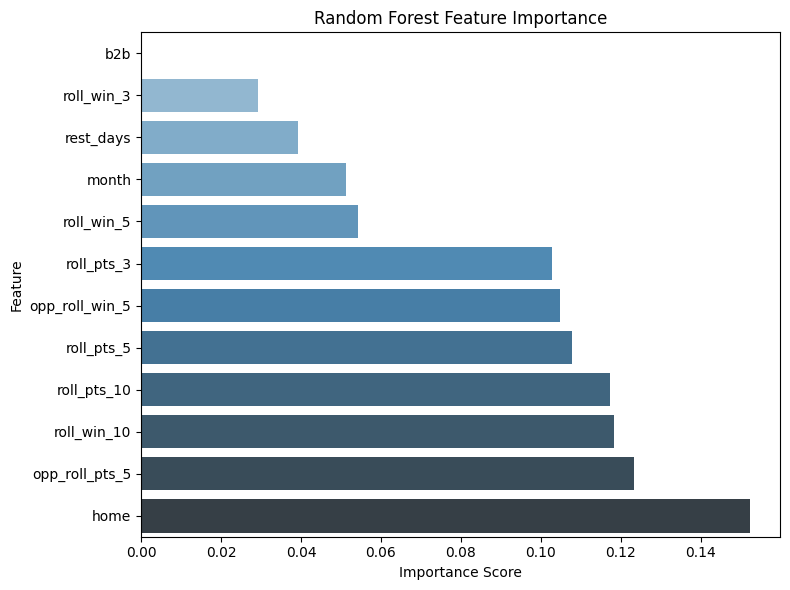

In [13]:
# === Step 10: Feature Importance Visualization (Random Forest) ===
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# get feature importances
rf_model = rf.named_steps["randomforestclassifier"]
importance = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=True)

# plot
plt.figure(figsize=(8,6))
sns.barplot(x=importance, y=importance.index, palette="Blues_d")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

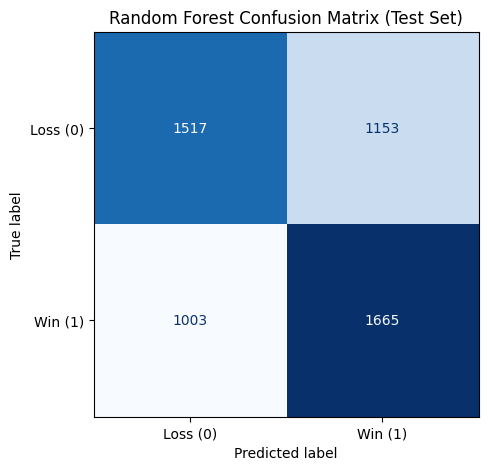

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on test set
y_pred = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss (0)", "Win (1)"])

# Plot
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.show()

In [15]:
!pip install nba_api

In [16]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

# example: pull 2023–24 regular season games
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2023-24')
games_2024 = gamefinder.get_data_frames()[0]

# preview
games_2024.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42023,1.610613e+09,BOS,Boston Celtics,0042300405,2024-06-17,BOS vs. DAL,W,240,106,...,0.850,15,36,51,25,9,2,7,15,18.0
1,42023,1.610613e+09,DAL,Dallas Mavericks,0042300405,2024-06-17,DAL @ BOS,L,240,88,...,0.538,7,28,35,18,4,4,13,20,-18.0
2,42023,1.610613e+09,BOS,Boston Celtics,0042300404,2024-06-14,BOS @ DAL,L,239,84,...,0.923,4,27,31,18,2,5,13,19,-38.0
3,42023,1.610613e+09,DAL,Dallas Mavericks,0042300404,2024-06-14,DAL vs. BOS,W,240,122,...,0.682,13,39,52,21,7,2,8,17,38.0
4,42023,1.610613e+09,BOS,Boston Celtics,0042300403,2024-06-12,BOS @ DAL,W,240,106,...,0.929,6,30,36,26,4,6,9,19,7.0


In [17]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss

# Try XGBoost, fallback to HistGradientBoosting
use_xgb = True
try:
    from xgboost import XGBClassifier
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    use_xgb = False

In [18]:
g_elo = g.sort_values('date').copy()
g_elo['date'] = pd.to_datetime(g_elo['date'])

# ELO parameters
K = 20.0
HOME_ADV = 60.0

teams = pd.Index(sorted(g_elo['team'].unique()))
elo = pd.Series(1500.0, index=teams)

pre_elo, pre_opp_elo = [], []

for _, row in g_elo.iterrows():
    t, o, at_home = row['team'], row['opp'], bool(row['home'])
    e_t = elo[t] + (HOME_ADV if at_home else 0.0)
    e_o = elo[o] + (0.0 if at_home else HOME_ADV)

    pre_elo.append(e_t)
    pre_opp_elo.append(e_o)

    exp_t = 1 / (1 + 10 ** ((e_o - e_t) / 400))
    s_t = 1 if row['win'] == 1 else 0
    elo[t] += K * (s_t - exp_t)

g_elo['elo_pre'] = pre_elo
g_elo['opp_elo_pre'] = pre_opp_elo

In [19]:
# Basic add-ons (no leakage)
g_elo['b2b'] = (g_elo['rest_days'] == 0).astype(int)
g_elo['month'] = g_elo['date'].dt.month.astype(int)

# rest differential vs same-date average (pregame proxy; does not use outcome)
g_elo['rest_diff'] = g_elo['rest_days'] - g_elo.groupby('date')['rest_days'].transform('mean')

# --- PRE-GAME streak (no leakage) ---
# We need the number of consecutive wins (positive) or losses (negative) BEFORE this game.
def pregame_signed_streak(w: pd.Series) -> pd.Series:
    # map results to +1/-1, then SHIFT(1) so it's pregame
    signed = w.replace({1: 1, 0: -1})
    pre = signed.shift(1).fillna(0)  # pre-game value (0 for very first game)

    # build streak from 'pre': when sign changes (or zero), reset
    streak = []
    run = 0
    last_sign = 0
    for val in pre:
        sign = int(np.sign(val))
        if sign == 0:
            run = 0
        elif sign == last_sign:
            run += sign
        else:
            run = sign
        streak.append(run)
        last_sign = sign
    return pd.Series(streak, index=w.index, dtype='int32')

g_elo['streak'] = (
    g_elo.groupby('team', group_keys=False)['win']
         .apply(pregame_signed_streak)
)

In [20]:
required = [
    'home','rest_days','b2b','month',
    'roll_win_3','roll_win_5','roll_win_10',
    'roll_pts_3','roll_pts_5','roll_pts_10',
    'opp_roll_win_5','opp_roll_pts_5',
    'elo_pre','opp_elo_pre','rest_diff','streak'
]

missing = [c for c in required if c not in g_elo.columns]
for c in missing:
    g_elo[c] = 0.0
print("Created missing feature placeholders:", missing)

Created missing feature placeholders: []


In [21]:
gx = g_elo.sort_values('date').reset_index(drop=True)
X = gx[required].astype(float).values
y = gx['win'].astype(int).values

n = len(gx)
i1, i2 = int(n*0.8), int(n*0.9)
X_train, y_train = X[:i1], y[:i1]
X_valid, y_valid = X[i1:i2], y[i1:i2]
X_test,  y_test  = X[i2:],  y[i2:]

print(f"sizes: {X_train.shape[0]} {X_valid.shape[0]} {X_test.shape[0]}")
print("ranges:", gx['date'].min(), "→", gx['date'].iloc[i1],
      "|", gx['date'].iloc[i1], "→", gx['date'].iloc[i2],
      "|", gx['date'].iloc[i2], "→", gx['date'].max())
if use_xgb:
    base = XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=-1, objective='binary:logistic',
        eval_metric='logloss'
    )
    param_grid = {
        'xgbclassifier__max_depth': [3,4,5],
        'xgbclassifier__n_estimators': [300,500],
        'xgbclassifier__learning_rate': [0.03,0.05],
        'xgbclassifier__subsample': [0.8,1.0],
        'xgbclassifier__colsample_bytree': [0.8,1.0],
    }
else:
    from sklearn.ensemble import HistGradientBoostingClassifier
    base = HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.05, max_iter=400,
        l2_regularization=0.0, random_state=42
    )
    param_grid = {
        'histgradientboostingclassifier__max_depth': [3,4,5],
        'histgradientboostingclassifier__learning_rate': [0.03,0.05],
        'histgradientboostingclassifier__max_iter': [300,500],
    }

pipe = make_pipeline(SimpleImputer(strategy="median"), base)
tscv = TimeSeriesSplit(n_splits=3)

sizes: 42702 5338 5338
ranges: 2003-10-08 00:00:00 → 2018-12-18 00:00:00 | 2018-12-18 00:00:00 → 2021-02-19 00:00:00 | 2021-02-19 00:00:00 → 2022-12-22 00:00:00


In [22]:
# === Grid search on TRAIN only, keep VALID clean; then calibrate on VALID ===
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
import numpy as np

# time-series CV for model selection
tscv = TimeSeriesSplit(n_splits=3)

gs = GridSearchCV(
    pipe,                      # from your previous cell (imputer -> XGB/HistGB)
    param_grid=param_grid,     # from your previous cell
    scoring='neg_brier_score',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# fit ONLY on TRAIN (avoid leakage)
gs.fit(X_train, y_train)
best = gs.best_estimator_
print("Best params (train CV):", gs.best_params_)

# quick uncalibrated check on valid
def eval_raw(clf, X, y):
    p = clf.predict_proba(X)[:, 1]
    return dict(
        acc=accuracy_score(y, (p >= 0.5).astype(int)),
        auc=roc_auc_score(y, p),
        brier=brier_score_loss(y, p)
    )

raw_valid = eval_raw(best, X_valid, y_valid)
print("Valid (raw)  acc={acc:.3f}  auc={auc:.3f}  brier={brier:.3f}".format(**raw_valid))

# probability calibration on VALID (kept out of CV)
cal = CalibratedClassifierCV(best, cv='prefit', method='sigmoid')
cal.fit(X_valid, y_valid)

# final evaluation on all splits
def eval_split(name, clf, X, y):
    p = clf.predict_proba(X)[:, 1]
    return dict(
        acc=accuracy_score(y, (p >= 0.5).astype(int)),
        auc=roc_auc_score(y, p),
        brier=brier_score_loss(y, p)
    )

scores = {
    'train': eval_split('train', cal, X_train, y_train),
    'valid': eval_split('valid', cal, X_valid, y_valid),
    'test' : eval_split('test',  cal, X_test,  y_test)
}

print("\nHistGB/XGB (calibrated)")
for k, v in scores.items():
    print(f"  {k:>5}  acc={v['acc']:.3f}  auc={v['auc']:.3f}  brier={v['brier']:.3f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params (train CV): {'histgradientboostingclassifier__learning_rate': 0.03, 'histgradientboostingclassifier__max_depth': 3, 'histgradientboostingclassifier__max_iter': 300}
Valid (raw)  acc=0.636  auc=0.695  brier=0.222

HistGB/XGB (calibrated)
  train  acc=0.676  auc=0.745  brier=0.206
  valid  acc=0.634  auc=0.695  brier=0.221
   test  acc=0.650  auc=0.698  brier=0.221


In [23]:
!pip install shap --quiet

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make a clean DataFrame for interpretability
feature_names = [
    'home','rest_days','b2b','month',
    'roll_win_3','roll_win_5','roll_win_10',
    'roll_pts_3','roll_pts_5','roll_pts_10',
    'opp_roll_win_5','opp_roll_pts_5',
    'elo_pre','opp_elo_pre','rest_diff','streak'
]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [24]:
# Extract the fitted model (inside the best pipeline)
tree_model = (
    best.named_steps.get('xgbclassifier')
    if use_xgb
    else best.named_steps.get('histgradientboostingclassifier')
)
tree_model

HistGradientBoostingClassifier(learning_rate=0.03, max_depth=3, max_iter=300,
                               random_state=42)

In [25]:
# 1) Use the SAME imputer as training, but feed numpy (no name mismatch warning)
imputer = best.named_steps['simpleimputer']

n_samples = min(1000, len(X_test_df))
X_shap_raw = X_test_df.sample(n=n_samples, random_state=42)

# transform with .values to avoid the feature-name warning from sklearn
X_shap_imp_arr = imputer.transform(X_shap_raw.values)
X_shap_imp = pd.DataFrame(X_shap_imp_arr, columns=X_test_df.columns)

# 2) Provide a background dataset for interventional mode
bg = X_shap_imp.sample(n=min(500, len(X_shap_imp)), random_state=42)

# 3) Build explainer on PROBABILITY output with background (no future warning)
tree_model = (best.named_steps.get('xgbclassifier')
              if use_xgb
              else best.named_steps.get('histgradientboostingclassifier'))

explainer = shap.TreeExplainer(
    tree_model,
    data=bg,                               # background for interventional
    feature_perturbation="interventional",
    model_output="probability"
)

# 4) Compute SHAP values; disable strict additivity (common for prob outputs)
shap_values = explainer(X_shap_imp, check_additivity=False)
print("SHAP values shape:", np.array(shap_values.values).shape)

SHAP values shape: (1000, 16)


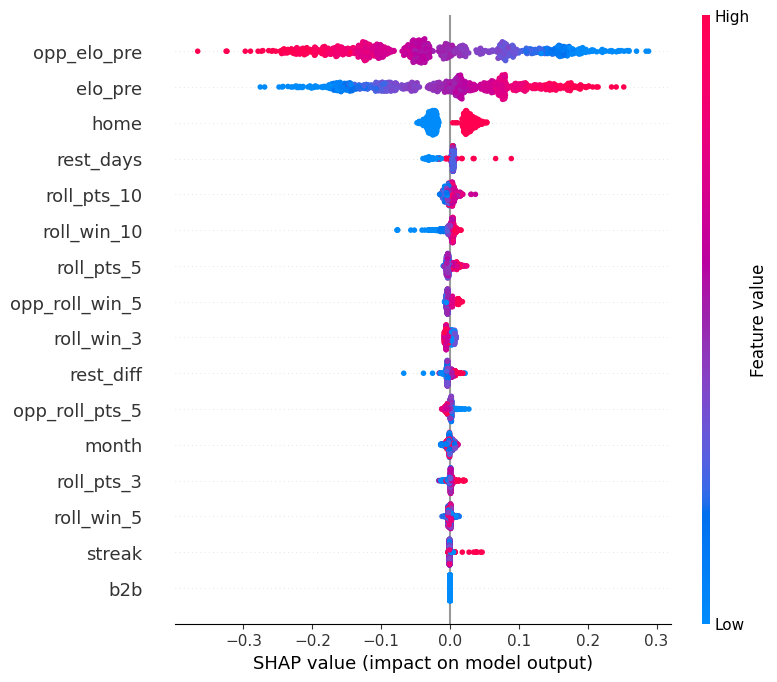

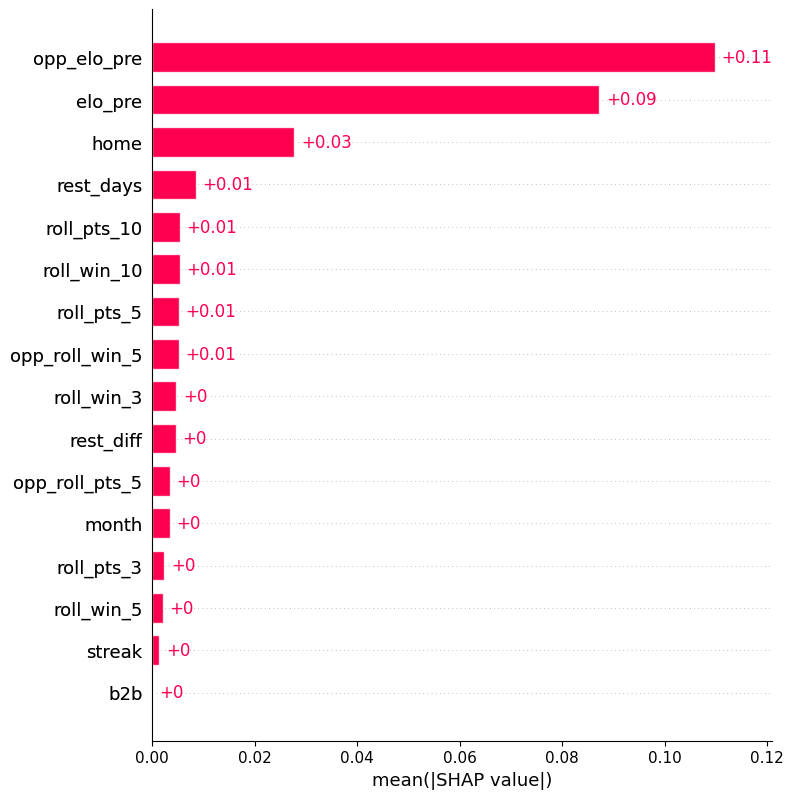

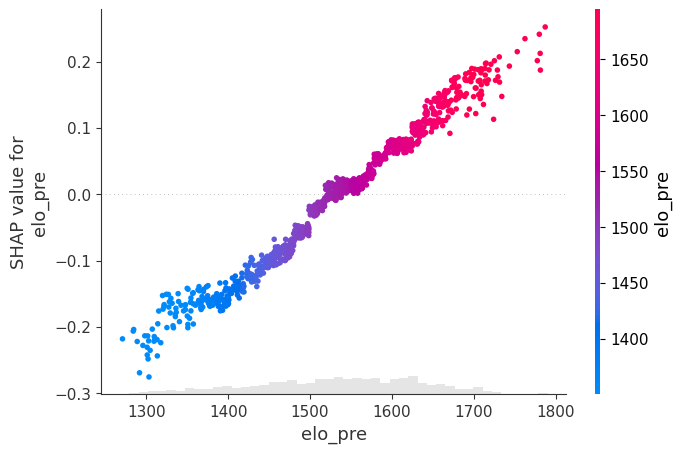

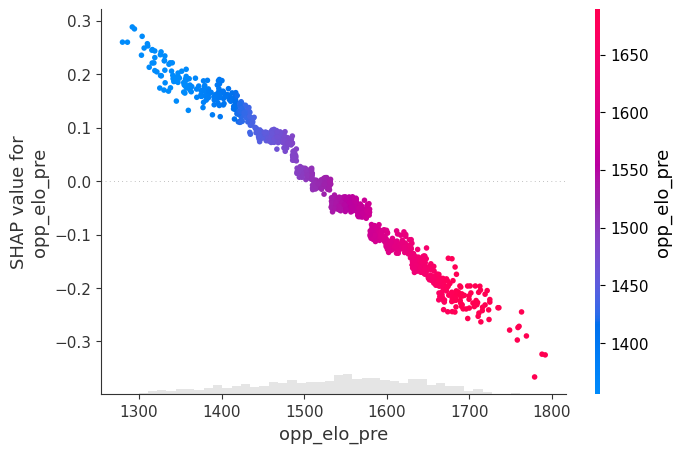

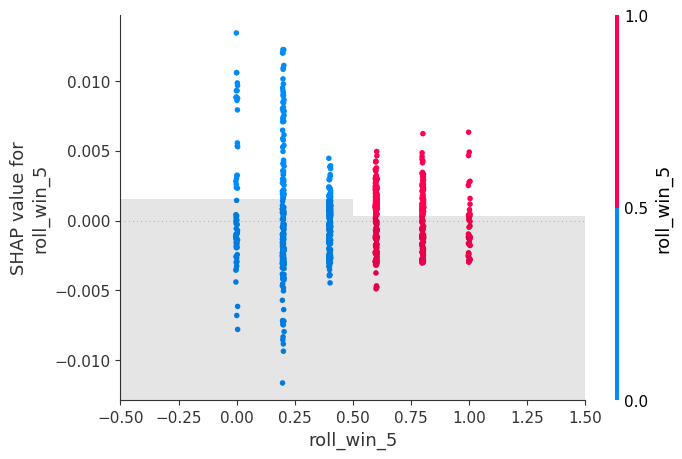

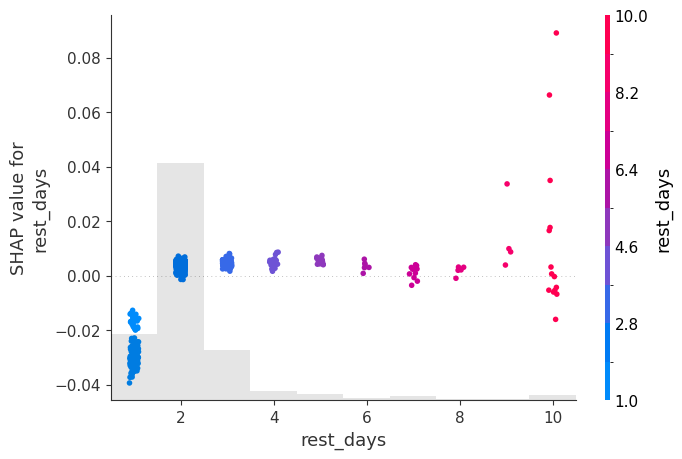

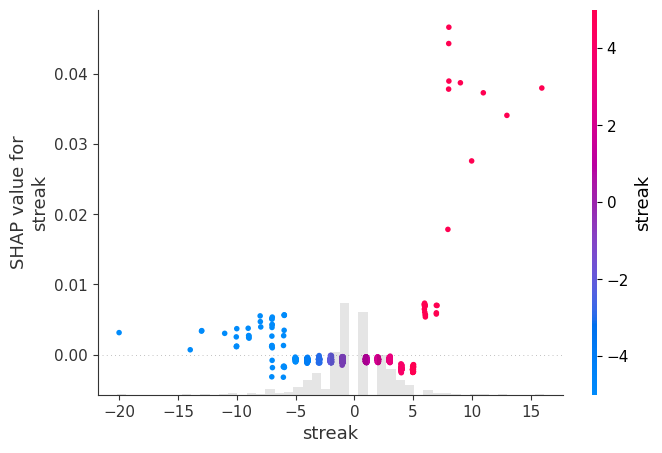

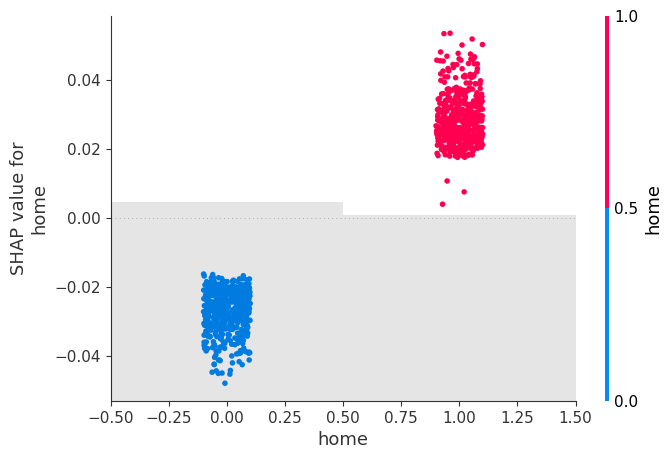

In [26]:
# Global
shap.plots.beeswarm(shap_values, max_display=16, show=True)
shap.plots.bar(shap_values, max_display=16, show=True)

# Dependence (feature-by-feature)
for feat in ['elo_pre','opp_elo_pre','roll_win_5','rest_days','streak','home']:
    shap.plots.scatter(shap_values[:, feat], color=shap_values[:, feat], show=True)

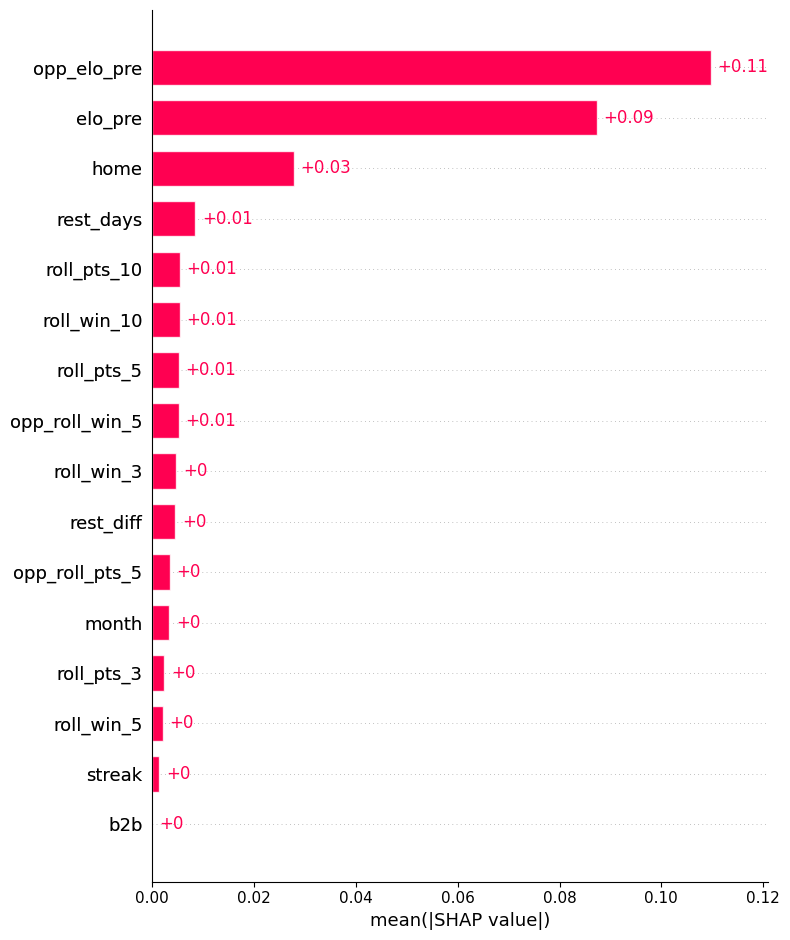

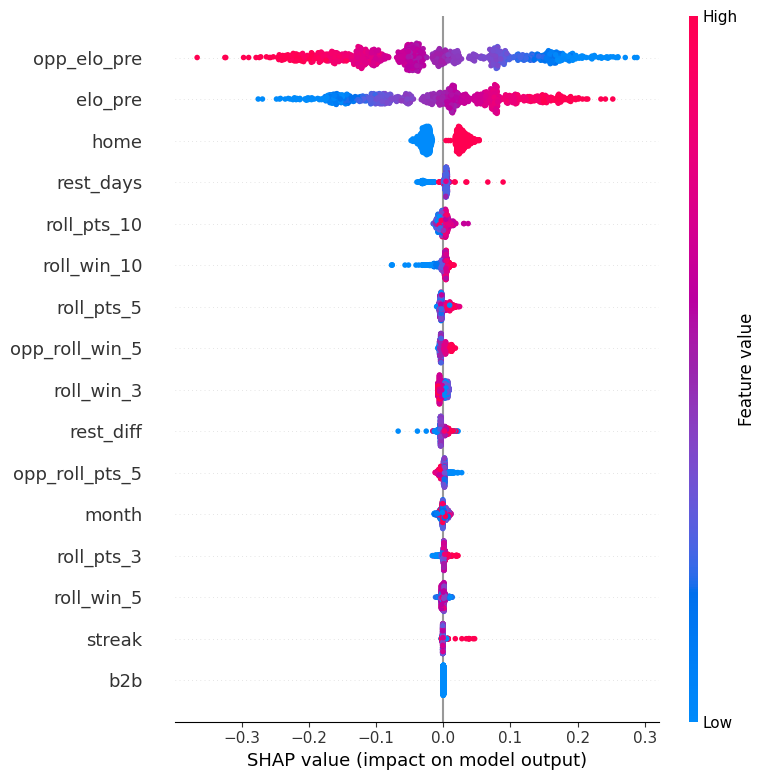

In [27]:
import matplotlib.pyplot as plt
plt.figure()
shap.plots.bar(shap_values, max_display=16, show=False)
plt.tight_layout(); plt.savefig("fig_feature_importance.png", dpi=200)

plt.figure()
shap.plots.beeswarm(shap_values, max_display=16, show=False)
plt.tight_layout(); plt.savefig("fig_beeswarm.png", dpi=200)